In [60]:
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import numpy as np
import pandas as pd
import re


In [61]:
# Read the data
df_comments1 = pd.read_pickle('./pickle_dataframes/comments1.pkl')
df_comments2 = pd.read_pickle('./pickle_dataframes/comments2.pkl')
df_comments = pd.concat([df_comments1,df_comments2])
df_comments.reset_index(drop=True, inplace=True)

df_posts1 = pd.read_pickle('./pickle_dataframes/posts1.pkl')
df_posts2 = pd.read_pickle('./pickle_dataframes/posts2.pkl')
df_posts3 = pd.read_pickle('./pickle_dataframes/posts3.pkl')
df_posts = pd.concat([df_posts1, df_posts2, df_posts3])
df_posts.reset_index(drop=True, inplace=True)

df_postlinks = pd.read_pickle('./pickle_dataframes/posts_links.pkl')
df_tags = pd.read_pickle('./pickle_dataframes/tags.pkl')
df_users = pd.read_pickle('./pickle_dataframes/users.pkl')

### Take a look at our DFs

In [62]:
df_comments.head()

,Id,PostId,Score,Text,CreationDate,UserId
0,1,1,9,Is it fair to inquire about the disadvantages ...,2012-12-04 22:00:00.933,28
1,3,1,3,"I could have reformulated the question, but at...",2012-12-04 22:02:37.737,18
2,7,2,2,Source on this? I don't see how it could possi...,2012-12-04 22:10:10.070,45
3,13,2,1,@Nick122 In a parliamentary system like the No...,2012-12-04 22:14:33.463,43
4,15,2,0,"Yes, but you will give a negative vote by voti...",2012-12-04 22:16:29.437,45


In [63]:
df_posts.head()

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount
0,1,1,-1,5,2012-12-04 21:40:29.743,42,8309,<p>We all know the situation could arise in th...,18,2019-06-29 09:18:38.430,What are the disadvantages of first-past-the-p...,<election><voting-systems><first-past-the-post>,3,3
1,2,1,-1,19,2012-12-04 21:53:18.800,26,7832,<p>I've heard that mathematically it can be sh...,21,2017-05-03 13:53:26.063,Why can't voting be fair if there are more tha...,<voting><political-theory><voting-systems>,4,3
2,4,2,1,-1,2012-12-04 21:58:11.187,7,-1,<p>First-past-the-post voting tends to result ...,26,2012-12-04 21:58:11.187,Comment: N/A,Comment: N/A,-1,1
3,5,2,1,-1,2012-12-04 21:58:39.037,47,-1,<p>Simple plurality voting has very little in ...,8,2012-12-04 22:04:42.767,Comment: N/A,Comment: N/A,-1,1
4,6,1,-1,28,2012-12-04 21:58:47.500,46,68096,<p>Living in a country where mandatory voting ...,18,2019-02-03 17:38:05.237,What are the advantages/disadvantages of a man...,<voting><voting-systems>,8,5


### Filtering Posts

In [64]:
questions_df = df_posts[df_posts['PostTypeId'] == 1]

### Text preprocessing

In [65]:
def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove stopwords and Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)

In [66]:
# Apply the cleaning function to the Body and Title columns
questions_df['Body_cleaned'] = questions_df['Body'].apply(clean_text)
questions_df['Title_cleaned'] = questions_df['Title'].apply(clean_text)

C:\Users\pih\AppData\Local\Temp\ipykernel_18456\4228383089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_df['Body_cleaned'] = questions_df['Body'].apply(clean_text)
c:\Users\pih\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\pih\AppData\Local\Temp\ipykernel_18456\4228383089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [67]:
questions_df.head()

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,Body_cleaned,Title_cleaned
0,1,1,-1,5,2012-12-04 21:40:29.743,42,8309,<p>We all know the situation could arise in th...,18,2019-06-29 09:18:38.430,What are the disadvantages of first-past-the-p...,<election><voting-systems><first-past-the-post>,3,3,know situation could arise u one candidate win...,disadvantage first past post electoral system
1,2,1,-1,19,2012-12-04 21:53:18.800,26,7832,<p>I've heard that mathematically it can be sh...,21,2017-05-03 13:53:26.063,Why can't voting be fair if there are more tha...,<voting><political-theory><voting-systems>,4,3,heard mathematically shown given voting system...,voting fair two alternative
4,6,1,-1,28,2012-12-04 21:58:47.500,46,68096,<p>Living in a country where mandatory voting ...,18,2019-02-03 17:38:05.237,What are the advantages/disadvantages of a man...,<voting><voting-systems>,8,5,living country mandatory voting exists experie...,advantage disadvantage mandatory voting system
5,7,1,-1,13,2012-12-04 22:08:50.417,83,10880,<p>When discussing political issues and partie...,20,2023-04-06 18:42:43.350,"What is meant by the ""left"" and the ""right""?",<parties><terminology><policy>,9,7,discussing political issue party often hear me...,meant left right
6,9,1,-1,18,2012-12-04 22:10:18.670,14,213,<p>I've read that some elections have instant ...,44,2017-06-14 13:06:44.500,How do instant runoffs work?,<election><voting><voting-systems>,1,1,read election instant runoff work differ stand...,instant runoff work


In [68]:
# TF-IDF Transformation
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(questions_df['Body_cleaned'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)  # Change n_components to the number of topics you want
lda.fit(tfidf)

# Assign topics to each document
topic_results = lda.transform(tfidf)
questions_df['Topic'] = topic_results.argmax(axis=1)


C:\Users\pih\AppData\Local\Temp\ipykernel_18456\1348888615.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions_df['Topic'] = topic_results.argmax(axis=1)


In [71]:
questions_df

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,Body_cleaned,Title_cleaned,Topic
0,1,1,-1,5,2012-12-04 21:40:29.743,42,8309,<p>We all know the situation could arise in th...,18,2019-06-29 09:18:38.430,What are the disadvantages of first-past-the-p...,<election><voting-systems><first-past-the-post>,3,3,know situation could arise u one candidate win...,disadvantage first past post electoral system,2
1,2,1,-1,19,2012-12-04 21:53:18.800,26,7832,<p>I've heard that mathematically it can be sh...,21,2017-05-03 13:53:26.063,Why can't voting be fair if there are more tha...,<voting><political-theory><voting-systems>,4,3,heard mathematically shown given voting system...,voting fair two alternative,9
4,6,1,-1,28,2012-12-04 21:58:47.500,46,68096,<p>Living in a country where mandatory voting ...,18,2019-02-03 17:38:05.237,What are the advantages/disadvantages of a man...,<voting><voting-systems>,8,5,living country mandatory voting exists experie...,advantage disadvantage mandatory voting system,2
5,7,1,-1,13,2012-12-04 22:08:50.417,83,10880,<p>When discussing political issues and partie...,20,2023-04-06 18:42:43.350,"What is meant by the ""left"" and the ""right""?",<parties><terminology><policy>,9,7,discussing political issue party often hear me...,meant left right,0
6,9,1,-1,18,2012-12-04 22:10:18.670,14,213,<p>I've read that some elections have instant ...,44,2017-06-14 13:06:44.500,How do instant runoffs work?,<election><voting><voting-systems>,1,1,read election instant runoff work differ stand...,instant runoff work,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52077,81110,1,-1,-1,2023-09-01 22:52:12.720,5,586,"<p><a href=""https://en.wikipedia.org/wiki/List...",28660,2023-09-02 02:40:38.250,Why does the ECB hold a large foreign currency...,<european-union><germany><ecb>,2,0,http en wikipedia org wiki list country foreig...,ecb hold large foreign currency reserve,9
52084,81117,1,-1,-1,2023-09-02 12:47:03.600,3,47,<blockquote>&#xA;<p>Last week 45 members of th...,28660,2023-09-02 13:01:57.217,What makes the way Russia handles its foreign ...,<russian-federation><central-bank>,0,6,last week 45 member european parliament wrote ...,make way russia handle foreign reserve complex,9
52086,81119,1,-1,-1,2023-09-02 18:41:26.820,3,149,"<p>Is it because they are so good, there is no...",29752,2023-09-03 04:27:06.580,Why do some US senators such as Mitch McConnel...,<united-states><democracy>,3,6,good one better therefore people keep voting d...,u senator mitch mcconnell dianne feinstein etc...,2
52088,81121,1,-1,-1,2023-09-03 00:41:14.053,-1,19,<p>Why won't American cities use sovereign wea...,28660,2023-09-03 00:41:14.053,Why won't American cities use sovereign wealth...,<united-states><law><finance>,0,1,american city use sovereign wealth fund fund c...,american city use sovereign wealth fund fund city,9


In [72]:
# Viewing the topics

feature_names = tfidf_vectorizer.get_feature_names_out()

# Define a function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top 10 words in each topic
display_topics(lda, feature_names, 10)

Topic 0:
eu uk party government country election parliament vote question state
Topic 1:
duke antifa nigeria unemployed railroad blockchain hdi opm bitcoin weed
Topic 2:
vote election candidate party state voter voting ballot republican president
Topic 3:
tamil nadu khan slovak realism imran noble functionality len eec
Topic 4:
guam dominion duterte ci utc latvian karabakh honourable nagorno industrialized
Topic 5:
russia nuclear war ukraine russian weapon military nato attack pakistan
Topic 6:
haiti warnock ig bail cryptocurrency castro ossoff unalienable hollywood cuba
Topic 7:
president senate house trump impeachment senator committee justice congress investigation
Topic 8:
kashmir steel prorogation kong hong thai minister shadow prorogue netanyahu
Topic 9:
country state government law people question china like right political


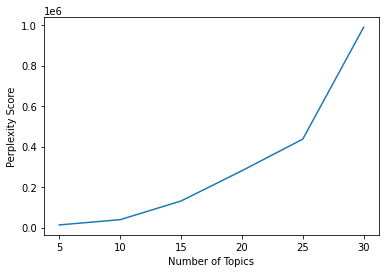

In [ ]:
# Perplexity is a statistical measure of how well a probability model predicts a sample. 
# In the context of LDA, lower perplexity might indicate a better model. 

# Example of calculating perplexity for different numbers of topics
n_topics = [5, 10, 15, 20, 25, 30]
perplexity_scores = []

for n in n_topics:
    lda = LatentDirichletAllocation(n_components=n, random_state=0)
    lda.fit(tfidf)
    perplexity_scores.append(lda.perplexity(tfidf))

# Plotting the perplexity scores
import matplotlib.pyplot as plt

plt.plot(n_topics, perplexity_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.show()

In [73]:
questions_df.to_pickle('questions_cleaned.pkl')